In [1]:
import re
import nltk
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Activation,Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Flatten,GlobalMaxPooling1D,Conv1D, Embedding, LSTM

In [2]:
dataset_path = '../data/IMDB_Dataset.csv'
df = pd.read_csv(dataset_path)
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


>Checking for null values:

In [5]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

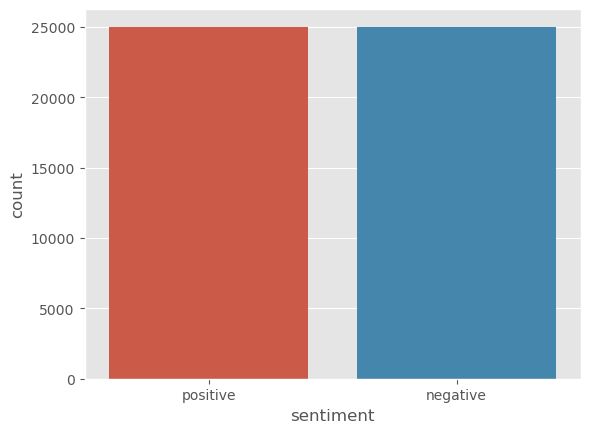

In [6]:
import seaborn as sns
plt.style.use("ggplot")
sns.countplot(data = df, x = df["sentiment"])
plt.show()

In [7]:
df["sentiment"].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

- So, there is no class imbalance both class has an equal number of data.

In [9]:
df["review"][2]

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

In [10]:
stopwords_list = set(stopwords.words('english'))


TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)
    

class CustomPreprocess():

    def __init__(self):
        pass

    def preprocess_text(self,sen):
        sen = sen.lower()
        
        # Remove html tags
        sentence = remove_tags(sen)

        # Remove punctuations and numbers
        sentence = re.sub('[^a-zA-Z]', ' ', sentence)
        
        # Single character removal
        sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

        # Remove multiple spaces
        sentence = re.sub(r'\s+', ' ', sentence)
        
        # Remove Stopwords
        pattern = re.compile(r'\b(' + r'|'.join(stopwords_list) + r')\b\s*')
        sentence = pattern.sub('', sentence)
        
        return sentence

In [11]:
custom = CustomPreprocess()
custom.preprocess_text("I thought this was a wonderful way to spend time on a too hot summer weekend")

'thought wonderful way spend time hot summer weekend'

In [12]:
x = []
sentences = list(df['review'])
for sen in sentences:
    x.append(custom.preprocess_text(sen))

In [13]:
y = df['sentiment']
sentiment_map = {'negative' : 0, 'positive': 1}
y = np.array(y.map(sentiment_map))
y[:15]

array([1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1])

In [14]:
x_train, x_test, y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

> Creating Embedding Layer:

> An embedding layer is typically used to convert words or tokens from a vocabulary into fixed-length dense vectors, often referred to as word embeddings or word vectors. Each word in the vocabulary is assigned a unique vector representation in the embedding space. These word embeddings are learned through the training process, where the model adjusts the values of the vectors to optimize the task at hand, such as sentiment analysis, machine translation, or text generation

In [16]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

In [17]:
import io
import json
tokenizer_json = tokenizer.to_json()

with io.open("tokenizer.json", 'w', encoding = "utf-8") as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii = False))

In [18]:
vocab_length = len(tokenizer.word_index)+1
vocab_length

92394

In [19]:
maxlen = 100

x_train = pad_sequences(x_train, padding='post', maxlen=maxlen)
x_test = pad_sequences(x_test, padding='post', maxlen=maxlen)

In [20]:
embedding_dict = dict()
glove_file = open("../data/glove.6B.100d.txt", encoding = 'utf8')
embeddings_dictionary = dict()
for line in glove_file:
    records = line.split()
    words = records[0]
    vector_dimensions = np.asarray(records[1:], dtype = 'float32')
    embeddings_dictionary[words] = vector_dimensions
glove_file.close()

In [21]:
print(list(tokenizer.word_index.items())[:15])

[('movie', 1), ('film', 2), ('one', 3), ('like', 4), ('good', 5), ('time', 6), ('even', 7), ('would', 8), ('story', 9), ('really', 10), ('see', 11), ('well', 12), ('much', 13), ('bad', 14), ('get', 15)]


In [22]:
embeddings_dictionary.get('film')

array([ 0.19916 , -0.049702,  0.24579 , -0.32281 ,  0.89768 , -0.1278  ,
       -0.49506 ,  0.20814 , -0.20046 , -0.20604 ,  0.038292, -0.67277 ,
       -0.12689 , -0.18766 , -0.10277 ,  0.73128 ,  0.82408 ,  0.087288,
        0.69255 ,  1.3107  ,  0.49113 , -0.38097 ,  0.24338 , -0.27813 ,
        0.62506 ,  0.35978 ,  0.42041 , -0.24529 ,  0.14861 , -0.26726 ,
       -0.56262 ,  0.63843 , -0.54153 ,  0.36537 ,  0.20545 , -0.16604 ,
        0.72434 ,  0.29961 , -0.42501 , -0.35932 , -0.089288,  0.48752 ,
       -1.0927  ,  0.88818 ,  0.89941 , -0.7541  , -0.35492 , -0.76396 ,
        0.27468 ,  0.2757  , -0.48152 , -0.41399 ,  0.64489 ,  1.148   ,
       -0.29131 , -2.9387  , -0.83162 ,  0.95586 ,  1.1623  , -0.42502 ,
        0.15486 ,  2.2326  , -0.31339 , -0.030228,  0.79802 , -0.41302 ,
        0.72885 ,  0.7296  , -0.31909 ,  0.8956  ,  0.34625 ,  0.2923  ,
        0.40056 ,  0.78985 , -0.43999 ,  0.24698 , -0.46548 ,  0.055886,
       -0.62603 , -0.036487, -0.65429 ,  0.10563 , 

In [23]:
embeddings_dictionary['film']

array([ 0.19916 , -0.049702,  0.24579 , -0.32281 ,  0.89768 , -0.1278  ,
       -0.49506 ,  0.20814 , -0.20046 , -0.20604 ,  0.038292, -0.67277 ,
       -0.12689 , -0.18766 , -0.10277 ,  0.73128 ,  0.82408 ,  0.087288,
        0.69255 ,  1.3107  ,  0.49113 , -0.38097 ,  0.24338 , -0.27813 ,
        0.62506 ,  0.35978 ,  0.42041 , -0.24529 ,  0.14861 , -0.26726 ,
       -0.56262 ,  0.63843 , -0.54153 ,  0.36537 ,  0.20545 , -0.16604 ,
        0.72434 ,  0.29961 , -0.42501 , -0.35932 , -0.089288,  0.48752 ,
       -1.0927  ,  0.88818 ,  0.89941 , -0.7541  , -0.35492 , -0.76396 ,
        0.27468 ,  0.2757  , -0.48152 , -0.41399 ,  0.64489 ,  1.148   ,
       -0.29131 , -2.9387  , -0.83162 ,  0.95586 ,  1.1623  , -0.42502 ,
        0.15486 ,  2.2326  , -0.31339 , -0.030228,  0.79802 , -0.41302 ,
        0.72885 ,  0.7296  , -0.31909 ,  0.8956  ,  0.34625 ,  0.2923  ,
        0.40056 ,  0.78985 , -0.43999 ,  0.24698 , -0.46548 ,  0.055886,
       -0.62603 , -0.036487, -0.65429 ,  0.10563 , 

In [24]:
embedding_matrix = np.zeros((vocab_length, 100)) #100
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [25]:
embedding_matrix.shape

(92394, 100)

> Model Building:
>> Simple Neural Network:

In [27]:
snn = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights = [embedding_matrix], input_length = maxlen, trainable = False)
snn.add(embedding_layer)
snn.add(Flatten())
snn.add(Dense(16, activation='relu'))
snn.add(Dense(1,activation = 'sigmoid'))

In [28]:
snn.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])
snn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          9239400   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 16)                160016    
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 9399433 (35.86 MB)
Trainable params: 160033 (625.13 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________


In [29]:
history_snn = snn.fit(x_train,y_train, batch_size=128, epochs = 10, 
                      verbose=1, validation_split =0.2)

Epoch 1/10
250/250 [==============================] - 0s 1ms/step - loss: 0.5460 - accuracy: 0.7200 - val_loss: 0.4936 - val_accuracy: 0.7631
Epoch 2/10
250/250 [==============================] - 0s 1ms/step - loss: 0.4191 - accuracy: 0.8074 - val_loss: 0.4949 - val_accuracy: 0.7664
Epoch 3/10
250/250 [==============================] - 0s 1ms/step - loss: 0.3585 - accuracy: 0.8403 - val_loss: 0.5164 - val_accuracy: 0.7574
Epoch 4/10
250/250 [==============================] - 0s 1ms/step - loss: 0.2989 - accuracy: 0.8733 - val_loss: 0.5384 - val_accuracy: 0.7594
Epoch 5/10
250/250 [==============================] - 0s 1ms/step - loss: 0.2394 - accuracy: 0.9031 - val_loss: 0.6320 - val_accuracy: 0.7510
Epoch 6/10
250/250 [==============================] - 0s 1ms/step - loss: 0.1871 - accuracy: 0.9298 - val_loss: 0.6853 - val_accuracy: 0.7494
Epoch 7/10
250/250 [==============================] - 0s 1ms/step - loss: 0.1366 - accuracy: 0.9540 - val_loss: 0.7391 - val_accuracy: 0.7404
Epoch 

In [30]:
result = snn.evaluate(x_test,y_test, verbose = 1)

313/313 [==============================] - 0s 343us/step - loss: 1.0553 - accuracy: 0.7247


In [31]:
print("Test Accuracy:", result[1])
print("Test Loss:", result[0])

Test Accuracy: 0.7246999740600586
Test Loss: 1.0552912950515747


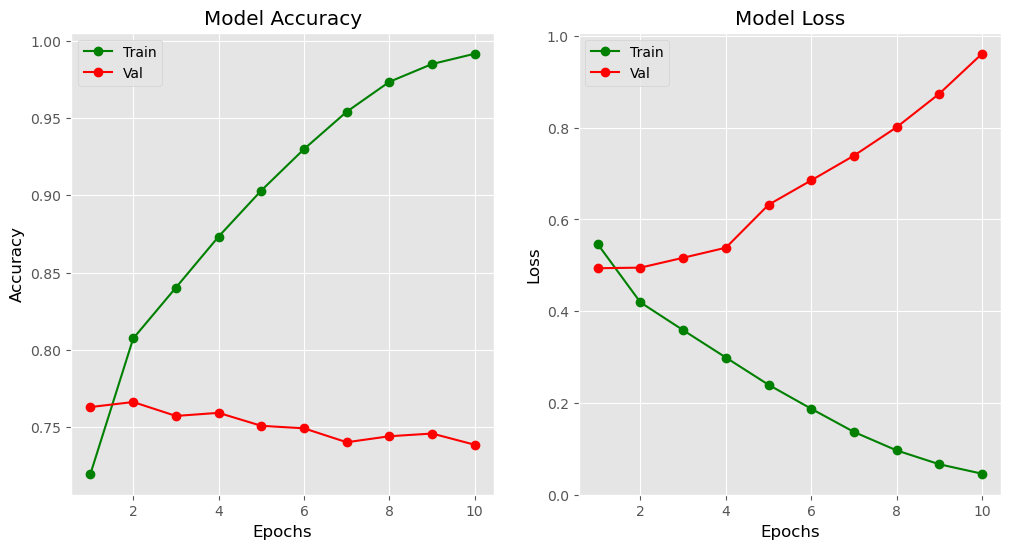

In [32]:
plt.figure(figsize=(12,6))
epochs = range(1,11)
plt.subplot(1,2,1)
plt.plot(epochs,history_snn.history["accuracy"],color = 'green', marker = 'o')
plt.plot(epochs,history_snn.history["val_accuracy"],color = 'red', marker = 'o')
plt.title("Model Accuracy")
plt.xlabel("Epochs",color = 'black')
plt.ylabel("Accuracy",color = 'black')
plt.legend(['Train','Val'],loc = "upper left")

plt.subplot(1,2,2)
plt.plot(epochs,history_snn.history["loss"],color = 'green', marker = 'o')
plt.plot(epochs,history_snn.history["val_loss"],color = 'red', marker = 'o')
plt.title("Model Loss")
plt.xlabel("Epochs",color = 'black')
plt.ylabel("Loss",color = 'black')
plt.legend(['Train','Val'],loc = "upper left")

plt.show()

> Convolutional Neural Network:

In [34]:
from keras.layers import Conv1D
cnn = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights = [embedding_matrix], input_length = maxlen, trainable = False)
cnn.add(embedding_layer)
cnn.add(Conv1D(128,5,activation = 'relu'))
cnn.add(Dropout(0.2))

cnn.add(Conv1D(256,5,activation = 'relu'))
cnn.add(GlobalMaxPooling1D())

cnn.add(Dense(1,activation = 'sigmoid'))

In [35]:
cnn.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          9239400   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           64128     
                                                                 
 dropout (Dropout)           (None, 96, 128)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 92, 256)           164096    
                                                                 
 global_max_pooling1d (Glob  (None, 256)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                      

In [36]:
history_cnn = cnn.fit(x_train,y_train, batch_size=128, epochs = 10, 
                      verbose=1, validation_split =0.2)

Epoch 1/10
250/250 [==============================] - 13s 50ms/step - loss: 0.4824 - accuracy: 0.7610 - val_loss: 0.3946 - val_accuracy: 0.8251
Epoch 2/10
250/250 [==============================] - 12s 50ms/step - loss: 0.3753 - accuracy: 0.8311 - val_loss: 0.3604 - val_accuracy: 0.8388
Epoch 3/10
250/250 [==============================] - 12s 50ms/step - loss: 0.3437 - accuracy: 0.8495 - val_loss: 0.3454 - val_accuracy: 0.8453
Epoch 4/10
250/250 [==============================] - 13s 50ms/step - loss: 0.2965 - accuracy: 0.8747 - val_loss: 0.3633 - val_accuracy: 0.8371
Epoch 5/10
250/250 [==============================] - 13s 50ms/step - loss: 0.2593 - accuracy: 0.8929 - val_loss: 0.3353 - val_accuracy: 0.8534
Epoch 6/10
250/250 [==============================] - 13s 51ms/step - loss: 0.2292 - accuracy: 0.9079 - val_loss: 0.3400 - val_accuracy: 0.8547
Epoch 7/10
250/250 [==============================] - 13s 51ms/step - loss: 0.1928 - accuracy: 0.9238 - val_loss: 0.3533 - val_accuracy:

In [37]:
cnn_result = cnn.evaluate(x_test,y_test, verbose = 1)
print("Test Accuracy:", cnn_result[1])
print("Test Loss:", cnn_result[0])

313/313 [==============================] - 1s 4ms/step - loss: 0.4220 - accuracy: 0.8392
Test Accuracy: 0.8392000198364258
Test Loss: 0.42204439640045166


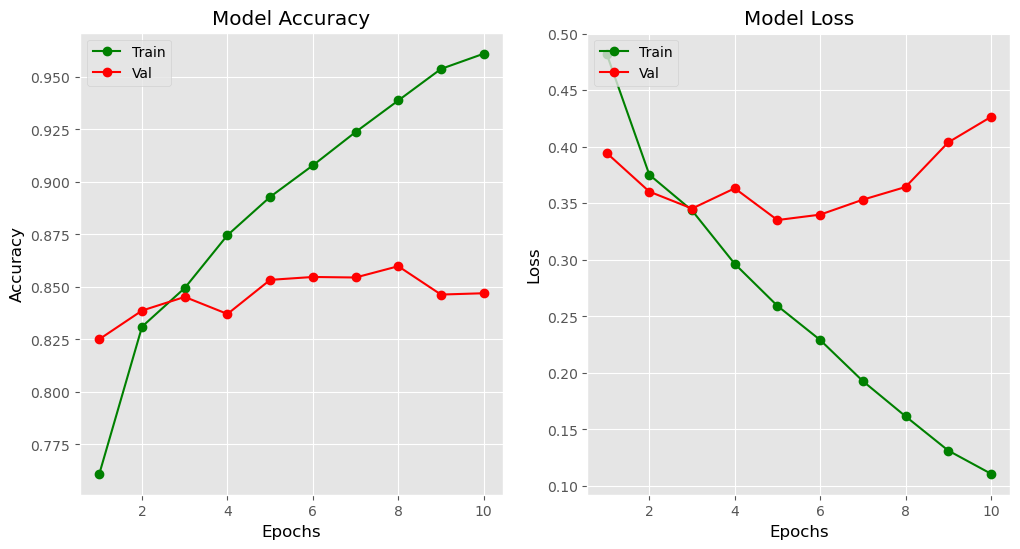

In [38]:
plt.figure(figsize=(12,6))
epochs = range(1,11)
plt.subplot(1,2,1)
plt.plot(epochs,history_cnn.history["accuracy"],color = 'green', marker = 'o')
plt.plot(epochs,history_cnn.history["val_accuracy"],color = 'red', marker = 'o')
plt.title("Model Accuracy")
plt.xlabel("Epochs",color = 'black')
plt.ylabel("Accuracy",color = 'black')
plt.legend(['Train','Val'],loc = "upper left")

plt.subplot(1,2,2)
plt.plot(epochs,history_cnn.history["loss"],color = 'green', marker = 'o')
plt.plot(epochs,history_cnn.history["val_loss"],color = 'red', marker = 'o')
plt.title("Model Loss")
plt.xlabel("Epochs",color = 'black')
plt.ylabel("Loss",color = 'black')
plt.legend(['Train','Val'],loc = "upper left")

plt.show()

> LSTM

In [40]:
lstm = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights = [embedding_matrix], input_length = maxlen, trainable = False)
lstm.add(embedding_layer)
lstm.add(LSTM(128)) #return_sequences=True
# lstm.add(LSTM(64, return_sequences=True))

# lstm.add(Dropout(0.2))
# lstm.add(LSTM(32))


# cnn.add(Conv1D(256,5,activation = 'relu'))
# cnn.add(GlobalMaxPooling1D())

lstm.add(Dense(1,activation = 'sigmoid'))

In [41]:
lstm.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])
lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          9239400   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9356777 (35.69 MB)
Trainable params: 117377 (458.50 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________


In [42]:
history_lstm = lstm.fit(x_train,y_train, batch_size=128, epochs = 10, 
                      verbose=1, validation_split =0.2)

Epoch 1/10
250/250 [==============================] - 24s 93ms/step - loss: 0.5017 - accuracy: 0.7546 - val_loss: 0.4447 - val_accuracy: 0.8075
Epoch 2/10
250/250 [==============================] - 23s 93ms/step - loss: 0.4181 - accuracy: 0.8139 - val_loss: 0.4029 - val_accuracy: 0.8320
Epoch 3/10
250/250 [==============================] - 23s 93ms/step - loss: 0.3693 - accuracy: 0.8399 - val_loss: 0.4103 - val_accuracy: 0.8112
Epoch 4/10
250/250 [==============================] - 23s 92ms/step - loss: 0.3445 - accuracy: 0.8531 - val_loss: 0.3230 - val_accuracy: 0.8637
Epoch 5/10
250/250 [==============================] - 23s 92ms/step - loss: 0.3245 - accuracy: 0.8628 - val_loss: 0.3288 - val_accuracy: 0.8580
Epoch 6/10
250/250 [==============================] - 23s 92ms/step - loss: 0.3018 - accuracy: 0.8739 - val_loss: 0.3116 - val_accuracy: 0.8706
Epoch 7/10
250/250 [==============================] - 23s 92ms/step - loss: 0.2838 - accuracy: 0.8827 - val_loss: 0.3184 - val_accuracy:

In [43]:
lstm_result = lstm.evaluate(x_test,y_test, verbose = 1)
print("Test Accuracy:", lstm_result[1])
print("Test Loss:", lstm_result[0])

313/313 [==============================] - 5s 16ms/step - loss: 0.3578 - accuracy: 0.8518
Test Accuracy: 0.8518000245094299
Test Loss: 0.3578107953071594


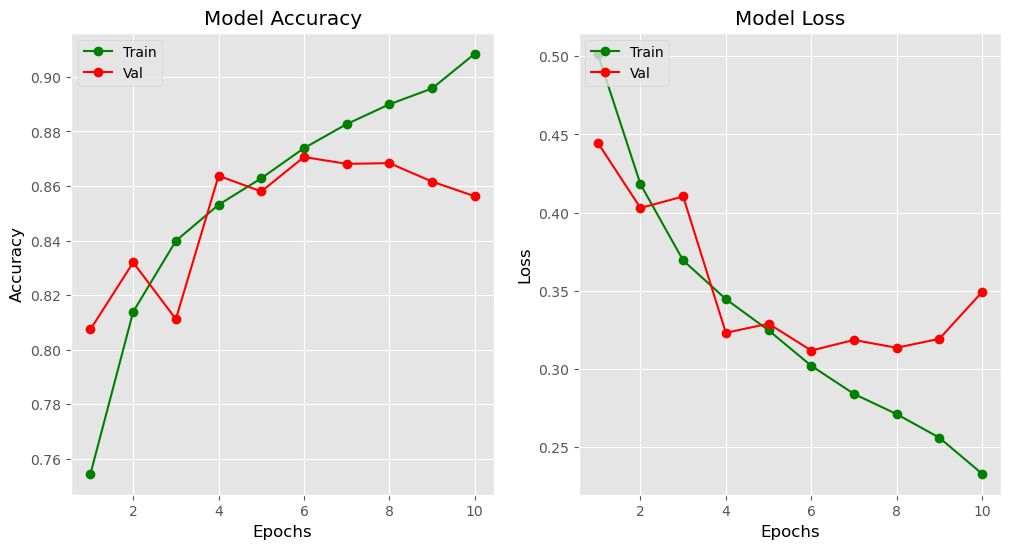

In [44]:
plt.figure(figsize=(12,6))
epochs = range(1, 11)
plt.subplot(1,2,1)
plt.plot(epochs,history_lstm.history["accuracy"],color = 'green', marker = 'o')
plt.plot(epochs,history_lstm.history["val_accuracy"],color = 'red', marker = 'o')
plt.title("Model Accuracy")
plt.xlabel("Epochs",color = 'black')
plt.ylabel("Accuracy",color = 'black')
plt.legend(['Train','Val'],loc = "upper left")

plt.subplot(1,2,2)
plt.plot(epochs,history_lstm.history["loss"],color = 'green', marker = 'o')
plt.plot(epochs,history_lstm.history["val_loss"],color = 'red', marker = 'o')
plt.title("Model Loss")
plt.xlabel("Epochs",color = 'black')
plt.ylabel("Loss",color = 'black')
plt.legend(['Train','Val'],loc = "upper left")

plt.show()

In [45]:
lstm.save("sentiment_classifier2.h5")

/Users/harshavardhan/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
